# svd_mcmc code demo

A demo of the how to use the code for doing/visualising SVD_MCMC. Replicates

In [1]:
import sys
sys.path.insert(0, "../")

import matplotlib.pyplot as plt
import numpy as np
import uq4pk_src as uq4pk

## Generate Mock Data

In [2]:
from jax import random
rng_key = random.PRNGKey(32743)

In [3]:
np.random.seed(82011)

In [4]:
snr = 300.
Theta_v_true = np.array([-150., 100., 1., 0., 0., -0.2, 0.05])
dv = 30.
lmd_min, lmd_max = 4000., 5000.

In [5]:
ssps = uq4pk.model_grids.MilesSSP(lmd_min=lmd_min, lmd_max=lmd_max)
df = uq4pk.distribution_function.RandomGMM_DistributionFunction(modgrid=ssps, fill_pars={'n':2,
                                                                                         'logsig_lo':-2,
                                                                                         'logsig_hi':-1.5})
op = uq4pk.observation_operator.ObservationOperator(ssps=ssps, dv=dv)
ybar = op.evaluate(df.F, Theta_v_true)
sigma_y = np.mean(np.abs(ybar))/snr
y = np.random.normal(ybar, sigma_y)

Distribution functions should have shape (12, 53)


In [6]:
from uq4pk_fit.inference import StatModel
from simulate_data import load_experiment_data
data = load_experiment_data("experiment_data")
forward_operator = data.get_forward_operator()
model = StatModel(y=y, y_sd=np.ones_like(y)*sigma_y, forward_operator=forward_operator)
# fabian's rule of thumb
regularisation_parameter = 1000.*snr
beta_tilde_prior_cov = (1./regularisation_parameter) * np.dot(model.P1.mat, model.P1.mat.T)
# adjust according to the expiriment in my notebook
beta_tilde_prior_cov = 100.*beta_tilde_prior_cov

/Users/pjethwa/miniconda3/envs/dcdirect/lib/python3.9/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(


Distribution functions should have shape (12, 53)
Distribution functions should have shape (12, 53)


## Setup

In [7]:
svd_mcmc = uq4pk.svd_mcmc.SVD_MCMC(
    ssps=ssps,
    Theta_v_true=Theta_v_true,
    y=y,
    ybar=ybar,
    sigma_y=sigma_y)

Distribution functions should have shape (12, 53)


In [8]:
svd_mcmc.set_q(15)

## Sampling

In [9]:
eta_alpha_model = svd_mcmc.get_eta_alpha_model(sigma_alpha=0.1, sigma_eta=0.1)
eta_alpha_sampler = svd_mcmc.get_mcmc_sampler(eta_alpha_model, num_warmup=500, num_samples=500)

In [10]:
eta_alpha_sampler.run(rng_key)

sample: 100%|█████████████████| 1000/1000 [00:06<00:00, 144.44it/s, 255 steps of size 5.65e-03. acc. prob=0.91]


In [11]:
eta_alpha_sampler.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      1.00      0.00      1.00      1.00      1.00    482.78      1.00
    eta[0]     -0.01      0.00     -0.01     -0.01     -0.01    477.31      1.00
    eta[1]     -0.00      0.00     -0.00     -0.00      0.00    620.30      1.00
    eta[2]     -0.03      0.00     -0.03     -0.03     -0.03    509.61      1.00
    eta[3]      0.00      0.00      0.00      0.00      0.01    599.27      1.00
    eta[4]      0.01      0.00      0.01      0.01      0.01    634.78      1.00
    eta[5]      0.01      0.00      0.01      0.01      0.01    434.51      1.00
    eta[6]     -0.00      0.00     -0.00     -0.00      0.00    228.21      1.00
    eta[7]      0.01      0.00      0.01      0.01      0.02    108.43      1.00
    eta[8]      0.03      0.00      0.03      0.03      0.04    118.61      1.00
    eta[9]      0.04      0.00      0.04      0.03      0.04    412.09      1.00
   eta[10]      0.03      0

In [12]:
eta_alpha_samples = eta_alpha_sampler.get_samples()

In [13]:
beta_tilde_model = svd_mcmc.get_beta_tilde_model(
    eta_alpha_samples=eta_alpha_samples,
    Sigma_beta_tilde=beta_tilde_prior_cov)
beta_tilde_sampler = svd_mcmc.get_mcmc_sampler(beta_tilde_model, num_warmup=50, num_samples=50)

In [14]:
beta_tilde_sampler.run(rng_key)

sample: 100%|███████████████████| 100/100 [00:23<00:00,  4.34it/s, 1023 steps of size 3.81e-04. acc. prob=0.93]


In [15]:
beta_tilde_sampler.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  beta_tilde[0]      0.00      0.00      0.00      0.00      0.00     10.24      1.06
  beta_tilde[1]      0.00      0.00      0.00      0.00      0.00     12.13      1.08
  beta_tilde[2]      0.00      0.00      0.00      0.00      0.00      8.14      1.06
  beta_tilde[3]      0.00      0.00      0.00      0.00      0.00      9.07      1.07
  beta_tilde[4]      0.00      0.00      0.00      0.00      0.00      8.84      1.15
  beta_tilde[5]      0.00      0.00      0.00      0.00      0.00      8.55      1.00
  beta_tilde[6]      0.00      0.00      0.00      0.00      0.00      7.72      1.26
  beta_tilde[7]      0.00      0.00      0.00      0.00      0.00      7.95      1.01
  beta_tilde[8]      0.00      0.00      0.00      0.00      0.00      6.81      1.19
  beta_tilde[9]      0.00      0.00      0.00      0.00      0.00     10.85      1.16
 beta_tilde[10]      0.00      0.00      0.00      0.

In [16]:
beta_tilde_samples = beta_tilde_sampler.get_samples()

In [17]:
beta_tilde_samples

{'beta_tilde': DeviceArray([[1.33365800e-04, 6.25780085e-04, 2.64688570e-04, ...,
               1.33650508e-04, 7.28083105e-05, 2.85783375e-04],
              [1.10629109e-04, 4.34787973e-04, 6.73338596e-04, ...,
               8.93386605e-05, 5.54303333e-05, 2.60750268e-04],
              [8.75480473e-05, 4.86041914e-04, 4.87143319e-04, ...,
               6.94166956e-05, 4.31747467e-05, 2.36699168e-04],
              ...,
              [1.35190217e-04, 4.45761543e-04, 3.46140412e-04, ...,
               1.41684752e-04, 3.43139953e-04, 2.10861559e-04],
              [1.19492026e-04, 2.73837359e-04, 2.83799629e-04, ...,
               1.53706875e-04, 2.36428445e-04, 3.76544689e-04],
              [1.41900426e-04, 2.82540132e-04, 2.56600033e-04, ...,
               1.09758766e-04, 1.21150559e-04, 3.22961569e-04]],            dtype=float32)}

## Posterior predictive (PP) plots

PP using the samples of eta and alpha,

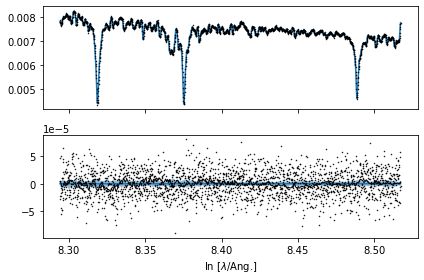

In [18]:
y_smp = svd_mcmc.get_pp_from_eta_alpha(eta_alpha_samples)
svd_mcmc.plot_posterior_predictve(y_smp)

PP using the samples of beta via eta and alpha,

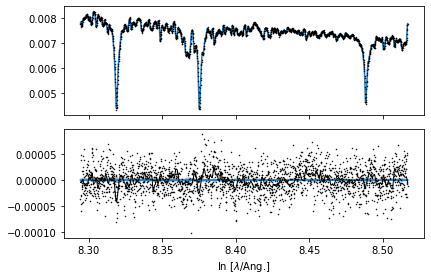

In [19]:
y_smp = svd_mcmc.get_pp_from_beta_tilde_via_lowdim(beta_tilde_samples)
svd_mcmc.plot_posterior_predictve(y_smp)

PP using the samples of beta directly,

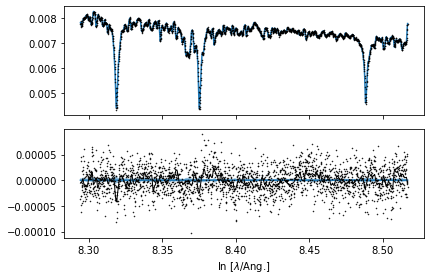

In [20]:
y_smp = svd_mcmc.get_pp_from_beta_tilde(beta_tilde_samples)
svd_mcmc.plot_posterior_predictve(y_smp)

## Visualise the posterior

Plot pixel-wise, e.g. the median,

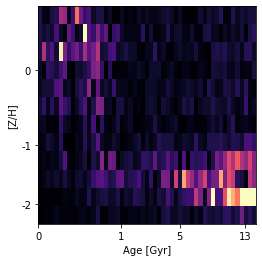

In [22]:
svd_mcmc.plot_pixel_wise_posterior_percentiles(beta_tilde_samples, percentile=50, clim=(0,10))

and the endpoints of the pixel-wise, even-tailed 90% credible interval,

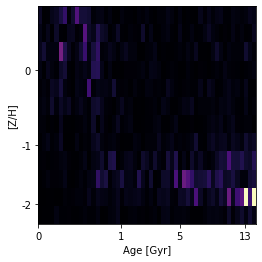

In [23]:
svd_mcmc.plot_pixel_wise_posterior_percentiles(beta_tilde_samples, percentile=5, clim=(0,10))

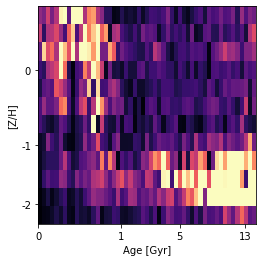

In [24]:
svd_mcmc.plot_pixel_wise_posterior_percentiles(beta_tilde_samples, percentile=95, clim=(0,10))